# Introduction

In this notebook we will be studying how to optimize a model changing the hyperparameters.

Example of what we want: given a decision tree model, we want to find out what is the value for max_depth that gives the best accuracy.

We could test the model with all values from a range, but it can be very time consuming.

The models have more than one parameter, decision tree classifiers also gave the min_samples_leaf parameter, so, what is the combination between max_depth and min_samples_leaf that gives the best accuracy? And with even more parameter? Let's find out.

In [1]:
import pandas as pd

uri = 'https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv'

# Loading our data and removing a column that we don't need
data = pd.read_csv(uri)\
    .drop(columns=['Unnamed: 0'], axis=1)\
    .rename(columns={'preco':'price', 'vendido': 'sold', 'idade_do_modelo': 'model_age', 'km_por_ano': 'km_per_year'})
data

,price,sold,model_age,km_per_year
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290
...,...,...,...,...
9995,97112.86,0,12,25060.64248
9996,107424.63,1,16,21317.31764
9997,93856.99,0,4,20950.38812
9998,51250.57,1,7,16840.13376


# What is a parameter

This content is a continuation of the cross-validation notebook

In [2]:
# Simulating a bad data disposition
bad_data = data.sort_values('sold', ascending=True)
x_bad = bad_data[['price', 'model_age', 'km_per_year']]
y_bad = bad_data['sold']
bad_data.head()
# To avoid this type of situation we can do cross validation

,price,sold,model_age,km_per_year
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [3]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import numpy as np

SEED = 301
np.random.seed(SEED)

model = DummyClassifier()

# cv is the number of folds to be used
results = cross_validate(model, x_bad, y_bad, cv=10, return_train_score=False)
mean = results['test_score'].mean()
standard_deviation = results['test_score'].std()
# Creating a baseline classifier
print(f"Accuracy with dummy stratified (10 folds): [{(mean-2*standard_deviation)*100:.2f}, {(mean+2*standard_deviation)*100:.2f}]")
# The precision is 58% for dummy

Accuracy with dummy stratified (10 folds): [58.00, 58.00]


In [4]:
# Crating a decision tree classifier as another point of view for baseline
from sklearn.tree import DecisionTreeClassifier

model2 = DecisionTreeClassifier(max_depth=2)
results2 = cross_validate(model2, x_bad, y_bad, cv=10, return_train_score=False)
mean2 = results2['test_score'].mean()
std2 = results2['test_score'].std()
print(f"Accuracy with decision tree (10 folds): [{(mean2-2*std2)*100:.2f}, {(mean2+2*std2)*100:.2f}]")
# Precision of 73% to 77% for decision tree

Accuracy with decision tree (10 folds): [73.83, 77.73]


In [5]:
# Generating the new categorical column for car model based on random data
# This model column is used to group the data
data['model'] = data.model_age + np.random.randint(-2, 3, size=len(data))
data.model = data.model + abs(data.model.min()) + 1
data.head()

,price,sold,model_age,km_per_year,model
0,30941.02,1,18,35085.22134,22
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,12
3,95276.14,0,3,43167.32682,3
4,117384.68,1,4,12770.11290,4


In [6]:
def print_results(results):
    mean = results['test_score'].mean()
    std = results['test_score'].std()
    print(f"Mean accuracy: {mean*100:.2f}")
    print(f"Confidence interval: [{(mean-2*std)*100:.2f}, {(mean+2*std)*100:.2f}]")
    print('------------------------')

In [7]:
# Cross validation grouping by car model
from sklearn.model_selection import GroupKFold

# We will be comparing 10 model variations, to see witch one yields the best results
cv = GroupKFold(n_splits=10)
model3 = DecisionTreeClassifier(max_depth=2)
results3 = cross_validate(model3, x_bad, y_bad, cv=cv, groups=data.model, return_train_score=False)
print_results(results3)
# Precision of 73% to 78% for decision tree with grouping

Mean accuracy: 75.79
Confidence interval: [73.37, 78.21]
------------------------


In [8]:
# Grouping in a pipeline with scaling and SVC classifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

scaler = StandardScaler()
model4 = SVC()
pipeline = Pipeline([('scaler', scaler), ('model', model4)])

cv = GroupKFold(n_splits=10)
results4 = cross_validate(pipeline, x_bad, y_bad, cv=cv, groups=data.model, return_train_score=False)
print_results(results4)
# Precision of 74% to 78% for svc with grouping

Mean accuracy: 76.56
Confidence interval: [74.94, 78.17]
------------------------


## Visualizing the tree of model3 with graphviz

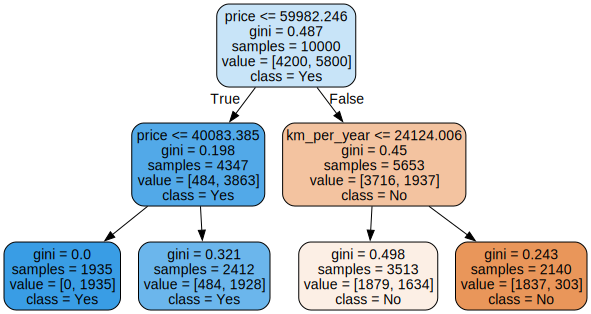

In [9]:
from sklearn.tree import export_graphviz
import graphviz

model3.fit(x_bad, y_bad)

# x columns: price, model_age and km_per_year
features = x_bad.columns
dot_data = export_graphviz(
    model3,
    out_file=None,
    filled=True,
    rounded=True,
    class_names=['No', 'Yes'],
    feature_names=features
)
graph = graphviz.Source(dot_data)
graph

In [10]:
# How would the tree perform if we change max_depth to 3?
cv = GroupKFold(n_splits=10)
model5 = DecisionTreeClassifier(max_depth=3)
results5 = cross_validate(model5, x_bad, y_bad, cv=cv, groups=data.model, return_train_score=False)
print_results(results5)
# Now the precision is varying between 76% and 81%, witch is better than with max_depth 2

Mean accuracy: 78.69
Confidence interval: [76.27, 81.12]
------------------------


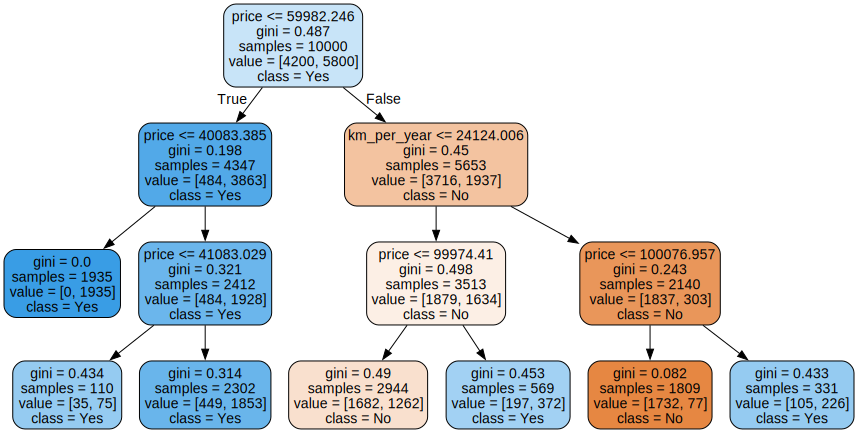

In [11]:
# Let's print the tree again
model5.fit(x_bad, y_bad)
dot_data2 = export_graphviz(
    model5,
    out_file=None,
    filled=True,
    rounded=True,
    class_names=['No', 'Yes'],
    feature_names=features
)
graph2 = graphviz.Source(dot_data2)
graph2

In [12]:
# If 3 is better than 2, what about 10?
model6 = DecisionTreeClassifier(max_depth=10)
results6 = cross_validate(model6, x_bad, y_bad, cv=cv, groups=data.model, return_train_score=False)
print_results(results6)
# Now we got 74% to 80%, witch is a little worse

Mean accuracy: 77.50
Confidence interval: [74.46, 80.54]
------------------------


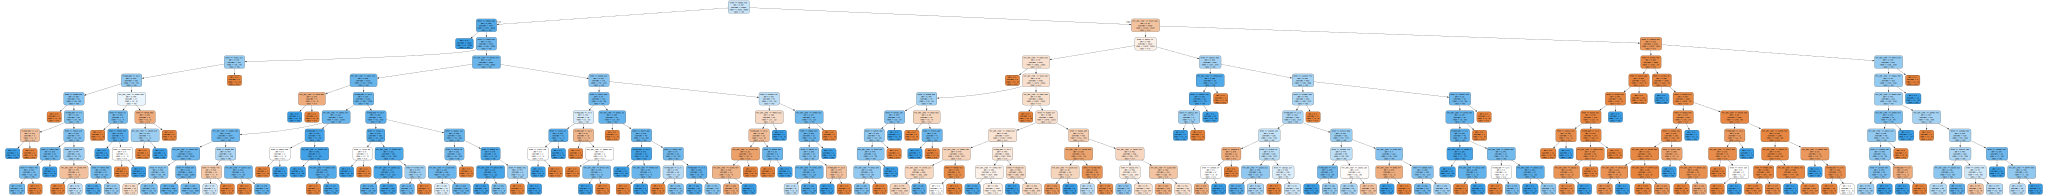

In [13]:
# Let's see the tree again
model6.fit(x_bad, y_bad)
dot_data3 = export_graphviz(
    model6,
    out_file=None,
    filled=True,
    rounded=True,
    class_names=['No', 'Yes'],
    feature_names=features
)
graph3 = graphviz.Source(dot_data3)
graph3
# It is difficult to analyse this tree visualization
# So, how can we choose the perfect value for max_depth?

# More complex trees are better?

In [14]:
# Testing parameters
def run_decision_tree(max_depth):
    cv = GroupKFold(n_splits=10)
    model = DecisionTreeClassifier(max_depth=max_depth)
    results = cross_validate(model, x_bad, y_bad, cv=cv, groups=data.model, return_train_score=False)
    print('Max depth: ', max_depth)
    print_results(results)

for i in range(1, 33):
    run_decision_tree(i)

# As we can see, from max_depth 5 and above the mean accuracy drops
# We could think that the more levels on the tree the better, but it is not what the results are showing us in this case
# The results that we are seeing are from the test step
# What must be happening is that the model is overfitting, case in witch the train result are very good but the test results are not
# It's as if the model is memorizing the data and results of the train step
# So, when the model receives new data it is not able to generalize

Max depth:  1
Mean accuracy: 75.79
Confidence interval: [73.37, 78.21]
------------------------
Max depth:  2
Mean accuracy: 75.79
Confidence interval: [73.37, 78.21]
------------------------
Max depth:  3
Mean accuracy: 78.69
Confidence interval: [76.27, 81.12]
------------------------
Max depth:  4
Mean accuracy: 78.67
Confidence interval: [76.25, 81.09]
------------------------
Max depth:  5
Mean accuracy: 78.62
Confidence interval: [76.15, 81.09]
------------------------
Max depth:  6
Mean accuracy: 78.40
Confidence interval: [75.95, 80.85]
------------------------
Max depth:  7
Mean accuracy: 78.29
Confidence interval: [75.85, 80.73]
------------------------
Max depth:  8
Mean accuracy: 78.12
Confidence interval: [75.82, 80.42]
------------------------
Max depth:  9
Mean accuracy: 77.97
Confidence interval: [75.31, 80.62]
------------------------
Max depth:  10
Mean accuracy: 77.52
Confidence interval: [74.33, 80.70]
------------------------
Max depth:  11
Mean accuracy: 77.13
Con

# Overfitting problem

In [15]:
# Let's print the train data on the function run_decision_tree
def run_decision_tree2(max_depth):
    cv = GroupKFold(n_splits=10)
    model = DecisionTreeClassifier(max_depth=max_depth)
    # We change return_train_score to True
    results = cross_validate(model, x_bad, y_bad, cv=cv, groups=data.model, return_train_score=True)
    train_score = results['train_score'].mean()*100
    test_score = results['test_score'].mean()*100
    print(f"Max depth: {max_depth}, Mean train: {train_score:.2f}, Mean test: {test_score:.2f}")
    # Let's save the results
    table = [max_depth, train_score, test_score]
    return table

results7 = [run_decision_tree2(i) for i in range(1, 33)]
results7 = pd.DataFrame(results7, columns=['max_depth', 'train', 'test'])
results7.head()

# As we can see, the precision for train keeps increasing

Max depth: 1, Mean train: 75.79, Mean test: 75.79
Max depth: 2, Mean train: 75.79, Mean test: 75.79
Max depth: 3, Mean train: 78.76, Mean test: 78.69
Max depth: 4, Mean train: 78.79, Mean test: 78.67
Max depth: 5, Mean train: 78.95, Mean test: 78.61
Max depth: 6, Mean train: 79.17, Mean test: 78.39
Max depth: 7, Mean train: 79.45, Mean test: 78.29
Max depth: 8, Mean train: 79.85, Mean test: 78.12
Max depth: 9, Mean train: 80.29, Mean test: 78.02
Max depth: 10, Mean train: 80.95, Mean test: 77.38
Max depth: 11, Mean train: 81.78, Mean test: 77.07
Max depth: 12, Mean train: 82.76, Mean test: 76.49
Max depth: 13, Mean train: 83.70, Mean test: 76.43
Max depth: 14, Mean train: 84.68, Mean test: 75.93
Max depth: 15, Mean train: 85.78, Mean test: 75.42
Max depth: 16, Mean train: 86.88, Mean test: 74.92
Max depth: 17, Mean train: 87.90, Mean test: 74.74
Max depth: 18, Mean train: 89.07, Mean test: 74.24
Max depth: 19, Mean train: 90.03, Mean test: 73.75
Max depth: 20, Mean train: 91.02, Mean t

,max_depth,train,test
0,1,75.791178,75.785553
1,2,75.791178,75.785553
2,3,78.755702,78.692170
3,4,78.787904,78.672305
4,5,78.949009,78.612812


/Users/danielgaio/.local/share/virtualenvs/python-ia-study-wV_J2Woc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danielgaio/.local/share/virtualenvs/python-ia-study-wV_J2Woc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danielgaio/.local/share/virtualenvs/python-ia-study-wV_J2Woc/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danielgaio/.local/share/virtualenvs/python-ia-study-wV_J

<Axes: xlabel='max_depth', ylabel='train'>

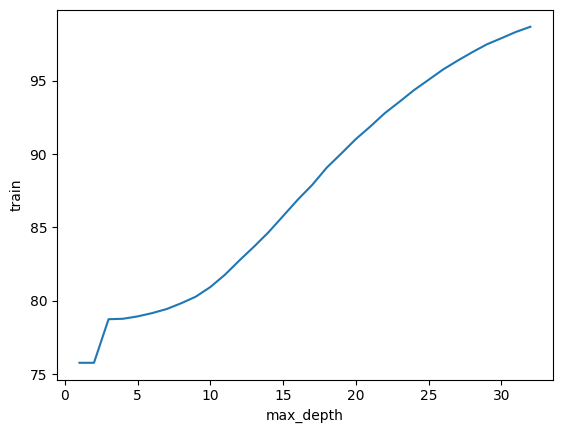

In [16]:
# Now that we have a dataframe of the results, let's visualize it
import seaborn as sns

# Curve for train
sns.lineplot(data=results7, x='max_depth', y='train')

## Overfit

/Users/danielgaio/.local/share/virtualenvs/python-ia-study-wV_J2Woc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danielgaio/.local/share/virtualenvs/python-ia-study-wV_J2Woc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danielgaio/.local/share/virtualenvs/python-ia-study-wV_J2Woc/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danielgaio/.local/share/virtualenvs/python-ia-study-wV_J

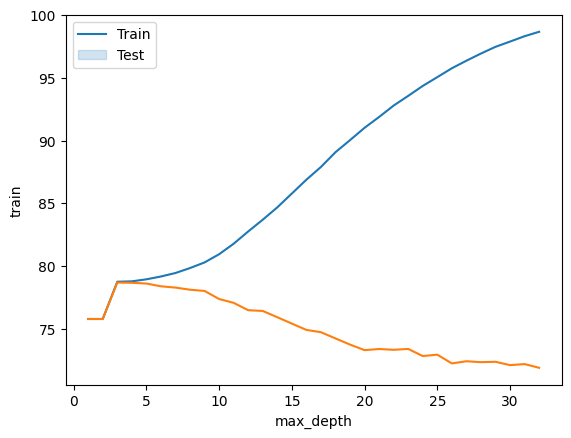

In [17]:
import matplotlib.pyplot as plt

# Visualizing the curves of train and test together
sns.lineplot(data=results7, x='max_depth', y='train')
sns.lineplot(data=results7, x='max_depth', y='test')
plt.legend(['Train', 'Test'])

# In the curves below we can see the overfitting, where the train curve goes up, but the test curve goes down

In [18]:
# If we sort the results by test we can get the value of max_depth that gives the best results
results7.sort_values('test', ascending=False).head()
# In this case max_depth 3 is the best

,max_depth,train,test
2,3,78.755702,78.692170
3,4,78.787904,78.672305
4,5,78.949009,78.612812
5,6,79.173472,78.391765
6,7,79.451312,78.290759


# Review parameter space exploration

To try out all possible values for a parameter may not always be possible, because if one test, for example, takes 5 minutes and you will explore a space of 30 possible values, it will take 2h 30m. And this time can be even longer.

How can we optimize this process?

# Parameter space of two dimensions

Now let's explore the combination of the hyperparameters max_depth and min_samples_leaf.

In this case we'l have a combination of each value of max_depth with all the values os min_samples_leaf.
For example:

max_depth=1 -> min_samples_leaf=1, 2, 3, ...

max_depth=2 -> min_samples_leaf=1, 2, 3, ...

...

Assuming that we have 64 possible for each parameter, we'l have a total of 64*64 = 4096 combinations, and if each execution takes 5 minutes, it'll take around 341 hours (14 days) of execution time to explore this space.

## Exploring hyperparameters in two dimensions

In [19]:
# Now the exploration considers two parameters
def run_decision_tree3(max_depth, min_samples_leaf):
    cv = GroupKFold(n_splits=10)
    model = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    results = cross_validate(model, x_bad, y_bad, cv=cv, groups=data.model, return_train_score=True)
    train_score = results['train_score'].mean()*100
    test_score = results['test_score'].mean()*100
    print(f"Max depth: {max_depth}, Min samples leaf: {min_samples_leaf}, Train: {train_score:.2f}, Test: {test_score:.2f}")
    table = [max_depth, min_samples_leaf, train_score, test_score]
    return table

def search(options_msl):
    results = []
    for max_depth in range(1, 33):
        #for min_samples_leaf in range(1, 33): # This takes a lot of time
        for min_samples_leaf in options_msl: # That's a way to explore a wide range without taking so long
            results.append(run_decision_tree3(max_depth, min_samples_leaf))
    results = pd.DataFrame(results, columns=['max_depth', 'min_samples_leaf', 'train_score', 'test_score'])
    return results

results8 = search(options_msl=[32, 64, 128, 256])
results8.head()

Max depth: 1, Min samples leaf: 32, Train: 75.79, Test: 75.79
Max depth: 1, Min samples leaf: 64, Train: 75.79, Test: 75.79
Max depth: 1, Min samples leaf: 128, Train: 75.79, Test: 75.79
Max depth: 1, Min samples leaf: 256, Train: 75.79, Test: 75.79
Max depth: 2, Min samples leaf: 32, Train: 75.79, Test: 75.79
Max depth: 2, Min samples leaf: 64, Train: 75.79, Test: 75.79
Max depth: 2, Min samples leaf: 128, Train: 75.79, Test: 75.79
Max depth: 2, Min samples leaf: 256, Train: 75.79, Test: 75.79
Max depth: 3, Min samples leaf: 32, Train: 78.75, Test: 78.70
Max depth: 3, Min samples leaf: 64, Train: 78.75, Test: 78.70
Max depth: 3, Min samples leaf: 128, Train: 78.75, Test: 78.70
Max depth: 3, Min samples leaf: 256, Train: 78.75, Test: 78.70
Max depth: 4, Min samples leaf: 32, Train: 78.75, Test: 78.70
Max depth: 4, Min samples leaf: 64, Train: 78.75, Test: 78.70
Max depth: 4, Min samples leaf: 128, Train: 78.75, Test: 78.70
Max depth: 4, Min samples leaf: 256, Train: 78.75, Test: 78.70


,max_depth,min_samples_leaf,train_score,test_score
0,1,32,75.791178,75.785553
1,1,64,75.791178,75.785553
2,1,128,75.791178,75.785553
3,1,256,75.791178,75.785553
4,2,32,75.791178,75.785553


In [20]:
results8.sort_values('test_score', ascending=False).head()
# max_depth: 4, min_samples_leaf: 21 (train_score=78.75, test_score=78.70) are the parameters that yeld the best results for an execution from 1 to 32 for both parameters
# Below are the results with min_samples_leaf from 32 to 256

,max_depth,min_samples_leaf,train_score,test_score
11,3,256,78.751263,78.702282
10,3,128,78.751263,78.702282
15,4,256,78.751263,78.702282
14,4,128,78.751263,78.702282
13,4,64,78.751263,78.702282


# Correlation matrix

What are the behavior of the train and test results when we change the hyperparameters?

We can see the correlation between the variables

In [21]:
corr = results8.corr()
corr
# When max_depth increases the train_score also increases
# When min_samples_leaf decreases the train_score also decreases
# Note: correlation does not mean causality

,max_depth,min_samples_leaf,train_score,test_score
max_depth,1.000000e+00,-2.780775e-16,0.539739,-0.023090
min_samples_leaf,-2.780775e-16,1.000000e+00,-0.413458,0.496616
train_score,5.397390e-01,-4.134577e-01,1.000000,0.103573
test_score,-2.309024e-02,4.966163e-01,0.103573,1.000000


<Axes: >

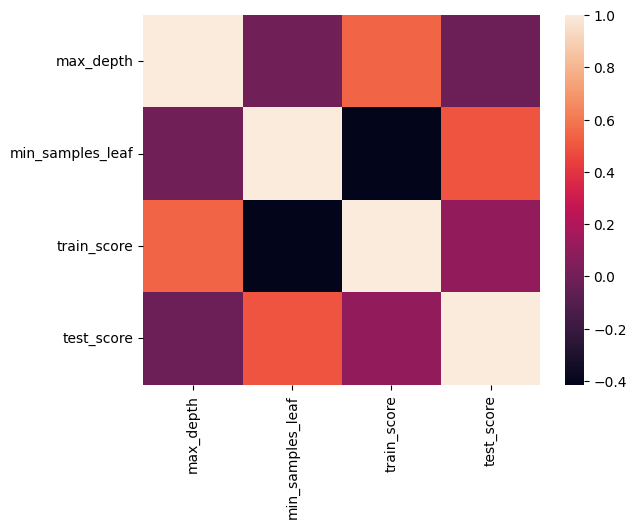

In [22]:
# Let's visualize the correlation
sns.heatmap(corr)
# We can see that greater max_depth increases train_score but decreases (or doesn't change) test_score

array([[<Axes: xlabel='max_depth', ylabel='max_depth'>,
        <Axes: xlabel='min_samples_leaf', ylabel='max_depth'>,
        <Axes: xlabel='train_score', ylabel='max_depth'>,
        <Axes: xlabel='test_score', ylabel='max_depth'>],
       [<Axes: xlabel='max_depth', ylabel='min_samples_leaf'>,
        <Axes: xlabel='min_samples_leaf', ylabel='min_samples_leaf'>,
        <Axes: xlabel='train_score', ylabel='min_samples_leaf'>,
        <Axes: xlabel='test_score', ylabel='min_samples_leaf'>],
       [<Axes: xlabel='max_depth', ylabel='train_score'>,
        <Axes: xlabel='min_samples_leaf', ylabel='train_score'>,
        <Axes: xlabel='train_score', ylabel='train_score'>,
        <Axes: xlabel='test_score', ylabel='train_score'>],
       [<Axes: xlabel='max_depth', ylabel='test_score'>,
        <Axes: xlabel='min_samples_leaf', ylabel='test_score'>,
        <Axes: xlabel='train_score', ylabel='test_score'>,
        <Axes: xlabel='test_score', ylabel='test_score'>]], dtype=object)

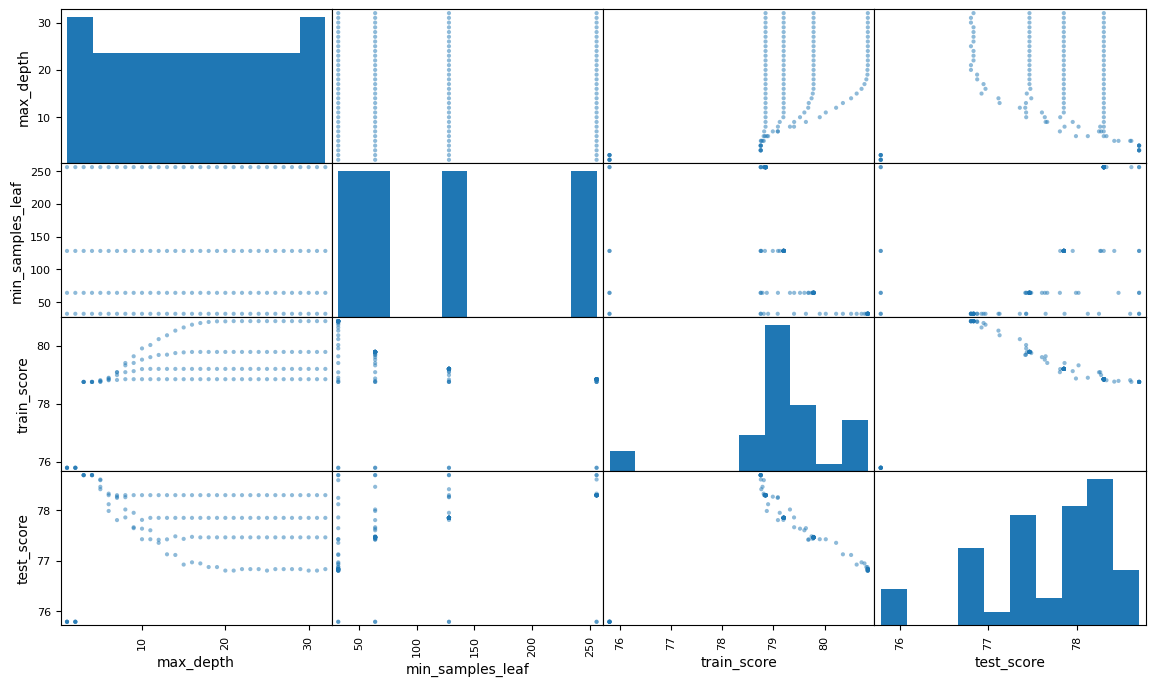

In [23]:
# Another way to visualize
pd.plotting.scatter_matrix(results8, figsize=(14, 8))
# The diagonal of the matrix shows a histogram of the values (the frequency of occurrence of each value)

/Users/danielgaio/.local/share/virtualenvs/python-ia-study-wV_J2Woc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danielgaio/.local/share/virtualenvs/python-ia-study-wV_J2Woc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danielgaio/.local/share/virtualenvs/python-ia-study-wV_J2Woc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danielgaio/.local/share/virtualenvs/python-ia-study-wV_J2Woc/lib/p

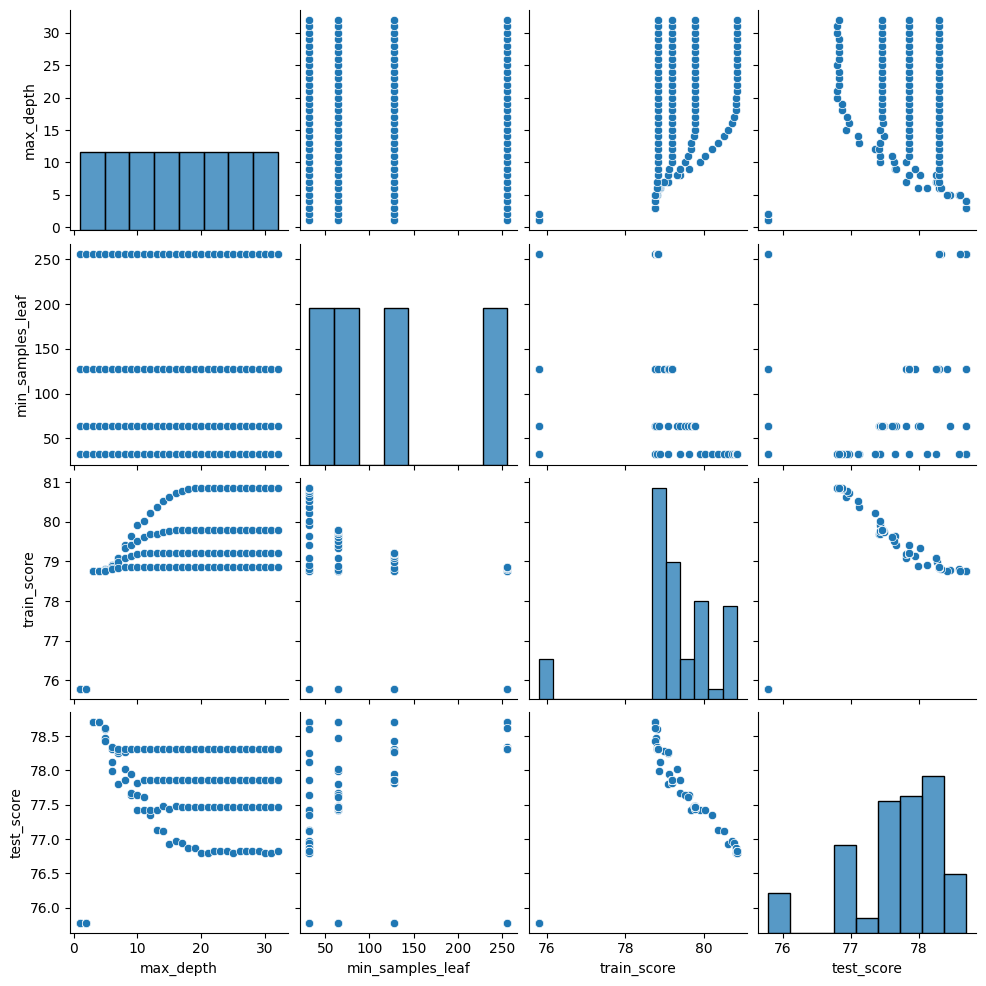

In [24]:
# Seaborn also have a similar plot
sns.pairplot(results8)

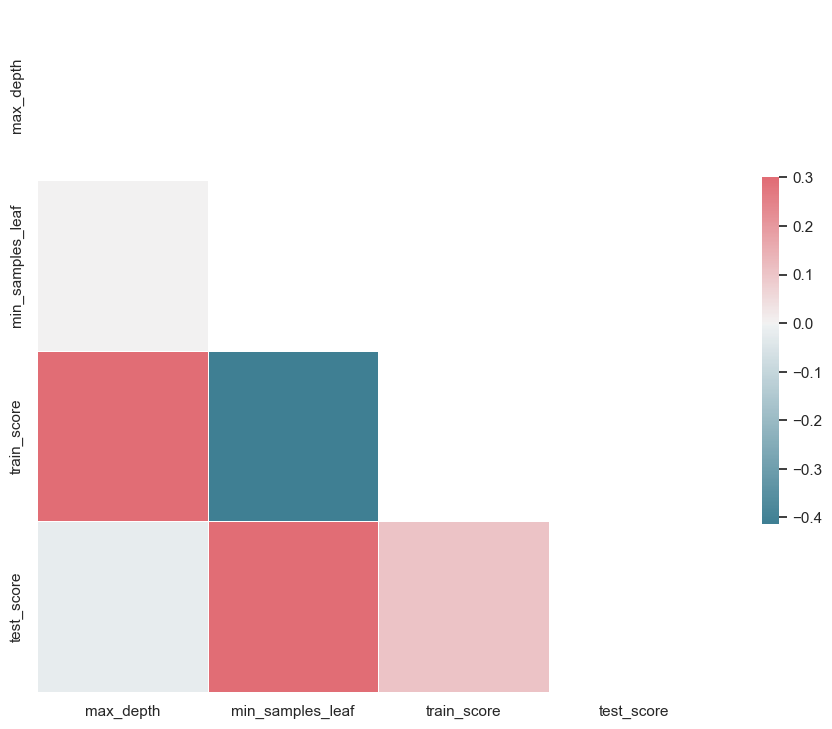

In [25]:
# And a more elaborate plot with seaborn
def plot_sns_corr(corr):
    sns.set(style='white')

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots()
    f.set_size_inches((11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={'shrink': .5})

plot_sns_corr(corr)
# It appears that min_samples_leaf is positively correlated with test_score, and max_depth isn't so much

In [26]:
# So we can explore greater values for min_samples_leaf
results9 = search(options_msl=[128, 192, 256, 512])

Max depth: 1, Min samples leaf: 128, Train: 75.79, Test: 75.79
Max depth: 1, Min samples leaf: 192, Train: 75.79, Test: 75.79
Max depth: 1, Min samples leaf: 256, Train: 75.79, Test: 75.79
Max depth: 1, Min samples leaf: 512, Train: 75.79, Test: 75.79
Max depth: 2, Min samples leaf: 128, Train: 75.79, Test: 75.79
Max depth: 2, Min samples leaf: 192, Train: 75.79, Test: 75.79
Max depth: 2, Min samples leaf: 256, Train: 75.79, Test: 75.79
Max depth: 2, Min samples leaf: 512, Train: 75.79, Test: 75.79
Max depth: 3, Min samples leaf: 128, Train: 78.75, Test: 78.70
Max depth: 3, Min samples leaf: 192, Train: 78.75, Test: 78.70
Max depth: 3, Min samples leaf: 256, Train: 78.75, Test: 78.70
Max depth: 3, Min samples leaf: 512, Train: 77.52, Test: 77.48
Max depth: 4, Min samples leaf: 128, Train: 78.75, Test: 78.70
Max depth: 4, Min samples leaf: 192, Train: 78.75, Test: 78.70
Max depth: 4, Min samples leaf: 256, Train: 78.75, Test: 78.70
Max depth: 4, Min samples leaf: 512, Train: 77.52, Test

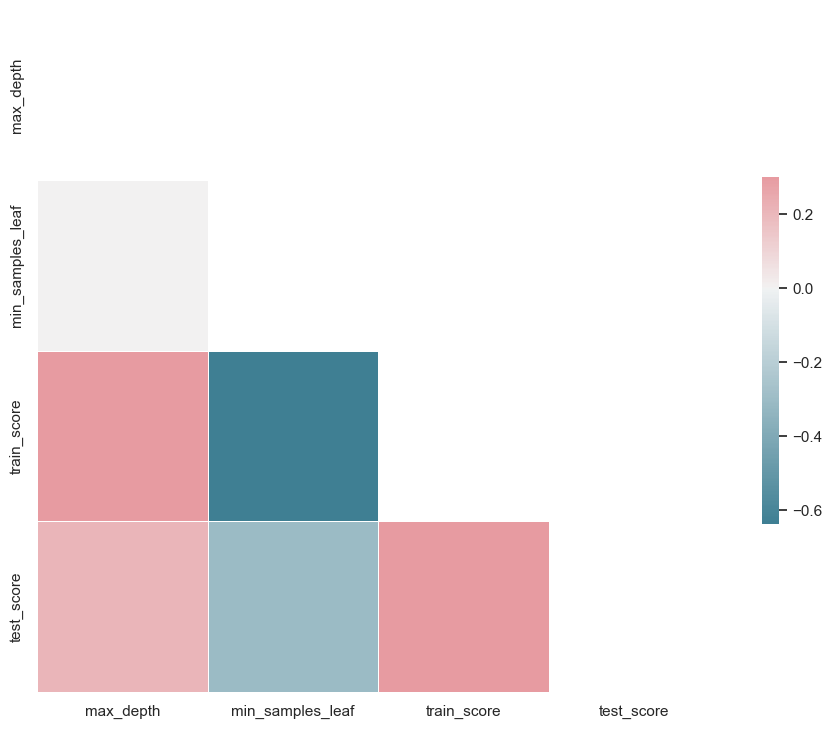

In [27]:
corr2 = results9.corr()
plot_sns_corr(corr2)
# This time test_score has a negative correlation with min_samples_leaf

In [28]:
# Let's see the best results
results9.sort_values('test_score', ascending=False).head()
# We can continue exploring parts of the space of possibilities this way, using different intervals ans analyzing the results

,max_depth,min_samples_leaf,train_score,test_score
14,4,256,78.751263,78.702282
8,3,128,78.751263,78.702282
9,3,192,78.751263,78.702282
10,3,256,78.751263,78.702282
12,4,128,78.751263,78.702282


# Exploring three or more parameters

Now we'll add to our exploration space the min_samples_split parameter

In [29]:
# Let's change our search function
def run_decision_tree4(max_depth, min_samples_leaf, min_samples_split):
    cv = GroupKFold(n_splits=10)
    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split
    )
    # The cross_validate function also return the execution time for training and testing
    results = cross_validate(model, x_bad, y_bad, cv=cv, groups=data.model, return_train_score=True)
    train_score = results['train_score'].mean()*100
    test_score = results['test_score'].mean()*100
    fit_time = results['fit_time'].mean()
    score_time = results['score_time'].mean()
    print(f"Max depth: {max_depth}, Min samples leaf: {min_samples_leaf}, Min samples split: {min_samples_split}, Train: {train_score:.2f}, Test: {test_score:.2f}")
    table = [max_depth, min_samples_leaf, min_samples_split, train_score, test_score, fit_time, score_time]
    return table

def search2():
    results = []
    for max_depth in range(1, 33):
        for min_samples_leaf in [32, 64, 128, 256]:
            for min_samples_split in [32, 64, 128, 256]:
                table = run_decision_tree4(max_depth, min_samples_leaf, min_samples_split)
                results.append(table)
    results = pd.DataFrame(
        results,
        columns=['max_depth', 'min_samples_leaf', 'min_samples_split', 'train_score', 'test_score', 'fit_time', 'score_time']
    )
    return results

results10 = search2()
results10.head()


Max depth: 1, Min samples leaf: 32, Min samples split: 32, Train: 75.79, Test: 75.79
Max depth: 1, Min samples leaf: 32, Min samples split: 64, Train: 75.79, Test: 75.79
Max depth: 1, Min samples leaf: 32, Min samples split: 128, Train: 75.79, Test: 75.79
Max depth: 1, Min samples leaf: 32, Min samples split: 256, Train: 75.79, Test: 75.79
Max depth: 1, Min samples leaf: 64, Min samples split: 32, Train: 75.79, Test: 75.79
Max depth: 1, Min samples leaf: 64, Min samples split: 64, Train: 75.79, Test: 75.79
Max depth: 1, Min samples leaf: 64, Min samples split: 128, Train: 75.79, Test: 75.79
Max depth: 1, Min samples leaf: 64, Min samples split: 256, Train: 75.79, Test: 75.79
Max depth: 1, Min samples leaf: 128, Min samples split: 32, Train: 75.79, Test: 75.79
Max depth: 1, Min samples leaf: 128, Min samples split: 64, Train: 75.79, Test: 75.79
Max depth: 1, Min samples leaf: 128, Min samples split: 128, Train: 75.79, Test: 75.79
Max depth: 1, Min samples leaf: 128, Min samples split: 2

,max_depth,min_samples_leaf,min_samples_split,train_score,test_score,fit_time,score_time
0,1,32,32,75.791178,75.785553,0.003403,0.000640
1,1,32,64,75.791178,75.785553,0.002925,0.000564
2,1,32,128,75.791178,75.785553,0.002876,0.000553
3,1,32,256,75.791178,75.785553,0.002764,0.000522
4,1,64,32,75.791178,75.785553,0.002740,0.000519


In [30]:
# Calculate the correlation
corr3 = results10.corr()
corr3

,max_depth,min_samples_leaf,min_samples_split,train_score,test_score,fit_time,score_time
max_depth,1.000000e+00,1.300685e-16,4.182375e-16,0.534455,0.035356,0.627288,0.610702
min_samples_leaf,1.300685e-16,1.000000e+00,0.000000e+00,-0.358084,0.404322,-0.473533,-0.051584
min_samples_split,4.182375e-16,0.000000e+00,1.000000e+00,-0.106862,0.163772,-0.070304,0.004511
train_score,5.344547e-01,-3.580836e-01,-1.068618e-01,1.000000,0.256630,0.900547,0.325678
test_score,3.535581e-02,4.043217e-01,1.637723e-01,0.256630,1.000000,-0.046767,-0.030541
fit_time,6.272880e-01,-4.735326e-01,-7.030430e-02,0.900547,-0.046767,1.000000,0.504830
score_time,6.107016e-01,-5.158432e-02,4.511379e-03,0.325678,-0.030541,0.504830,1.000000


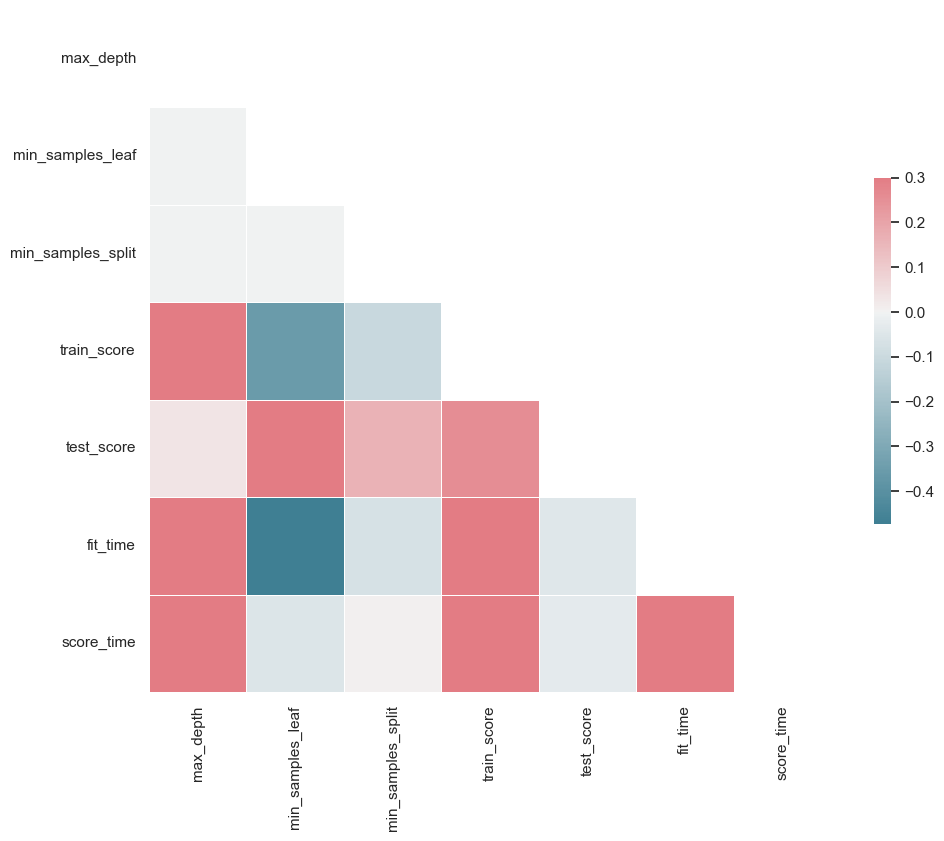

In [31]:
# Visualize the correlation matrix
plot_sns_corr(corr3)
# Apparently, if we increase min_samples_leaf the test_score will improve

In [32]:
# Get the 5 best results
results10.sort_values('test_score', ascending=False).head()
# The execution time can also be analyzed. If some combinations of parameter values present similar precision, we can opt for the one with the lowest execution time
# But how can we analyze even more parameters? Using the sklearn grid search.

,max_depth,min_samples_leaf,min_samples_split,train_score,test_score,fit_time,score_time
47,3,256,256,78.751263,78.702282,0.005864,0.000546
33,3,32,64,78.751263,78.702282,0.005901,0.000551
52,4,64,32,78.751263,78.702282,0.007189,0.000552
51,4,32,256,78.751263,78.702282,0.007087,0.000558
50,4,32,128,78.751263,78.702282,0.007174,0.000553


# GridSearchCV

Let's use the GridSearchCV to explore the parameters space

In [33]:
from sklearn.model_selection import GridSearchCV

# Now we added criterion as another dimension to explore
parameters_space = {
    'max_depth': [3, 5],
    'min_samples_split': [32, 64, 128],
    'min_samples_leaf': [32, 65, 128],
    'criterion': ['gini', 'entropy']
}

explore = GridSearchCV(DecisionTreeClassifier(), parameters_space, cv=GroupKFold(n_splits=10))
# This fit will run the train and test over all the combinations of our parameters
explore.fit(x_bad, y_bad, groups=data.model)
# The parameter cv_results_ contains the results of the executions for the different parameters
results11 = pd.DataFrame(explore.cv_results_)
results11.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007180,0.000656,0.000824,0.000078,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.793634,...,0.775531,0.775124,0.79803,0.7923,0.79103,0.806714,0.787234,0.787023,0.01202,1
1,0.005983,0.000155,0.000626,0.000080,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.793634,...,0.775531,0.775124,0.79803,0.7923,0.79103,0.806714,0.787234,0.787023,0.01202,1
2,0.006087,0.000158,0.000644,0.000104,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.793634,...,0.775531,0.775124,0.79803,0.7923,0.79103,0.806714,0.787234,0.787023,0.01202,1
3,0.005903,0.000131,0.000622,0.000088,gini,3,65,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.793634,...,0.775531,0.775124,0.79803,0.7923,0.79103,0.806714,0.787234,0.787023,0.01202,1
4,0.005890,0.000065,0.000604,0.000054,gini,3,65,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.793634,...,0.775531,0.775124,0.79803,0.7923,0.79103,0.806714,0.787234,0.787023,0.01202,1


In [34]:
# We also can just get the best parameters with the best_param_ variable
explore.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 32,
 'min_samples_split': 32}

In [35]:
# Ans the best score is on best_score_
f"{explore.best_score_*100:.2f}%"

'78.70%'

In [36]:
# We can also get the best model itself, already trained with the best parameters
best_model = explore.best_estimator_
best_model

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

In [37]:
from sklearn.metrics import accuracy_score

# Let's make predictions on the best model
predictions = best_model.predict(x_bad)
accuracy = accuracy_score(y_bad, predictions)
accuracy

0.7875

# Nested cross validation and validation of the chosen model

In [46]:
# If we just use a predict as we did on the last cell, the result will be too optimistic, because the data was already seen. So we should also use cross validation to predict, and that's called nested cross validation.

from sklearn.model_selection import cross_val_score

scores = cross_val_score(explore, x_bad, y_bad, cv=GroupKFold(n_splits=10), groups=data.model)

# The score for each of the splitted groups
scores

# There is a bug that prevents us from using the cross_val_score with the explore, GridSearchCV object.

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/danielgaio/.local/share/virtualenvs/python-ia-study-wV_J2Woc/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/danielgaio/.local/share/virtualenvs/python-ia-study-wV_J2Woc/lib/python3.9/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/danielgaio/.local/share/virtualenvs/python-ia-study-wV_J2Woc/lib/python3.9/site-packages/sklearn/model_selection/_search.py", line 898, in fit
    self._run_search(evaluate_candidates)
  File "/Users/danielgaio/.local/share/virtualenvs/python-ia-study-wV_J2Woc/lib/python3.9/site-packages/sklearn/model_selection/_search.py", line 1422, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "/Users/danielgaio/.local/share/virtualenvs/python-ia-study-wV_J2Woc/lib/python3.9/site-packages/sklearn/model_selection/_search.py", line 857, in evaluate_candidates
    for (cand_idx, parameters), (split_idx, (train, test)) in product(
  File "/Users/danielgaio/.local/share/virtualenvs/python-ia-study-wV_J2Woc/lib/python3.9/site-packages/sklearn/model_selection/_split.py", line 377, in split
    for train, test in super().split(X, y, groups):
  File "/Users/danielgaio/.local/share/virtualenvs/python-ia-study-wV_J2Woc/lib/python3.9/site-packages/sklearn/model_selection/_split.py", line 108, in split
    for test_index in self._iter_test_masks(X, y, groups):
  File "/Users/danielgaio/.local/share/virtualenvs/python-ia-study-wV_J2Woc/lib/python3.9/site-packages/sklearn/model_selection/_split.py", line 120, in _iter_test_masks
    for test_index in self._iter_test_indices(X, y, groups):
  File "/Users/danielgaio/.local/share/virtualenvs/python-ia-study-wV_J2Woc/lib/python3.9/site-packages/sklearn/model_selection/_split.py", line 563, in _iter_test_indices
    raise ValueError("The 'groups' parameter should not be None.")
ValueError: The 'groups' parameter should not be None.


In [47]:
from sklearn.model_selection import KFold

# So let's use a KFold instead of GroupKFold on the GridSearchCV
explore2 = GridSearchCV(
    DecisionTreeClassifier(),
    parameters_space,
    cv=KFold(n_splits=5, shuffle=True)
)
explore2.fit(x_bad, y_bad)
results12 = pd.DataFrame(explore2.cv_results_)
results12.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012177,0.010538,0.001576,0.000908,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.791,0.782,0.78,0.8005,0.782,0.7871,0.00771,1
1,0.006901,0.000675,0.001020,0.000104,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.791,0.782,0.78,0.8005,0.782,0.7871,0.00771,1
2,0.006217,0.000236,0.000926,0.000039,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.791,0.782,0.78,0.8005,0.782,0.7871,0.00771,1
3,0.005703,0.000317,0.000801,0.000110,gini,3,65,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.791,0.782,0.78,0.8005,0.782,0.7871,0.00771,1
4,0.005266,0.000114,0.000679,0.000076,gini,3,65,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.791,0.782,0.78,0.8005,0.782,0.7871,0.00771,1


In [48]:
# Now let's do the cross_val_score
scores2 = cross_val_score(explore2, x_bad, y_bad, cv=KFold(n_splits=5, shuffle=True))
scores2

array([0.7785, 0.7945, 0.7805, 0.7845, 0.7955])

In [51]:
# Let's get the mean and confidence interval
def print_score(scores):
    mean = scores.mean()*100
    std = scores.std()*100
    print(f"Mean accuracy: {mean}")
    print(f"Confidence interval: [{mean-2*std:.2f}, {mean+2*std:.2f}]")

print_score(scores2)

Mean accuracy: 78.67
Confidence interval: [77.26, 80.08]


In [54]:
# Those are the results for the best estimator
best_model2 = explore2.best_estimator_
best_model2

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

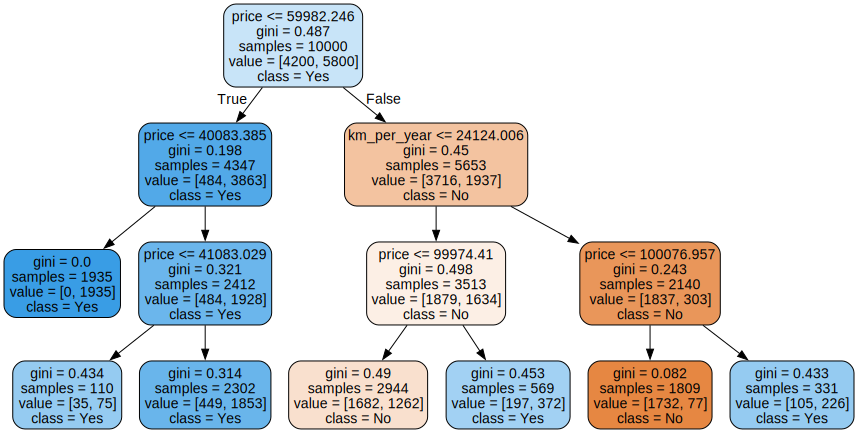

In [55]:
# Finally let's visualize the tree
dot_data4 = export_graphviz(
    best_model2,
    out_file=None,
    filled=True,
    rounded=True,
    class_names=['No', 'Yes'],
    feature_names=features
)

graph4 = graphviz.Source(dot_data4)
graph4